In [88]:
import tensorflow as tf
from keras.layers import Dropout, Dense, LSTM
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.models import Sequential
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt

In [2]:
# Load dataframe generated in sentiment_analysis.ipynb
df = pd.read_csv('sentiment_analysis.csv')

# Extract relevant columns for analysis
subset_df = df[['date', 'room_type', 'compound']]

# Convert 'date' column to datetime
subset_df['date'] = pd.to_datetime(subset_df['date'])

# Set 'date' column as index
subset_df.set_index('date', inplace=True)

# Unique room types
room_types = subset_df['room_type'].unique()

# Create scaler for data normalization later
scaler = MinMaxScaler()

display(subset_df.head())

C:\Temp\ipykernel_14496\1401669122.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['date'] = pd.to_datetime(subset_df['date'])


,room_type,compound
date,,
2016-05-29,Private room,0.9574
2016-08-26,Private room,0.9789
2017-06-10,Private room,0.7003
2017-09-28,Private room,0.9881
2017-10-15,Private room,0.2263


In [3]:
# Define input and output sequences for time series analysis
def create_sequences(data, seq_length):
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [74]:
# LSTM model defined by following function
def get_model(params, input_shape):
	model = Sequential()
	model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=False))
	model.add(Dropout(rate=params["dropout"]))

	model.add(Dense(1))

	model.compile(loss=params["loss"],
              	optimizer=params["optimizer"],
              	metrics=[RootMeanSquaredError(), MeanAbsoluteError(), 'mean_squared_error'])

	return model

In [107]:
def train_model_for_room_type(room_type, params, seq_length):
    # Extract room-specific data
    room_data = subset_df[subset_df['room_type'] == room_type]

    # Extract data up to February 2020-02-29 for training
    train_data = room_data[room_data.index <= pd.to_datetime('2020-02-29')]
    train_size = int(len(train_data) * 0.75)
    train, test = train_data[:train_size], train_data[train_size:]

    # Normalize data
    train_scaled = scaler.fit_transform(train[['compound']])
    test_scaled = scaler.transform(test[['compound']])

    # Create sequences
    x_train, y_train = create_sequences(train_scaled, seq_length)
    x_test, y_test = create_sequences(test_scaled, seq_length)

    # Reshape for LSTM
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Create and compile model
    model = get_model(params=params, input_shape=x_train.shape[1])

    # Early stopping
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_root_mean_squared_error', mode='min', patience=params["es_patience"]
    )

    # Monitor MSE for the best model
    checkpoint_filepath = os.path.join('saved_models', room_type, 'best_model.h5')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_mean_squared_error',
        mode='min',
        verbose=1
    )

    # Train the model
    model.fit(
        x_train,
        y_train,
        validation_data=(x_test, y_test),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        verbose=1,
        callbacks=[es_callback, model_checkpoint_callback]
    )

    # Load the best model
    best_model = tf.keras.models.load_model(checkpoint_filepath)

    return best_model, x_test, y_test


In [105]:
params = {
    "loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"lstm_units": 32,
	"epochs": 5,
	"batch_size": 256,
	"es_patience" : 5
}

seq_length = 10

In [119]:
best_models = {}

# Loop over room types and train models
for room_type in room_types:
    if room_type == 'Shared room':
        print(f"Training model for room type: {room_type}")
        best_model, _, _ = train_model_for_room_type(room_type, params, seq_length)
        best_models[room_type] = best_model

Training model for room type: Shared room
Epoch 1/5
8/8 [==============================] - ETA: 0s - loss: 0.5860 - root_mean_squared_error: 0.7655 - mean_absolute_error: 0.7340 - mean_squared_error: 0.5860
Epoch 1: val_mean_squared_error improved from inf to 0.34810, saving model to saved_models\Shared room\best_model.h5
8/8 [==============================] - 13s 588ms/step - loss: 0.5860 - root_mean_squared_error: 0.7655 - mean_absolute_error: 0.7340 - mean_squared_error: 0.5860 - val_loss: 0.3481 - val_root_mean_squared_error: 0.5900 - val_mean_absolute_error: 0.5616 - val_mean_squared_error: 0.3481
Epoch 2/5
8/8 [==============================] - ETA: 0s - loss: 0.1786 - root_mean_squared_error: 0.4227 - mean_absolute_error: 0.3668 - mean_squared_error: 0.1786
Epoch 2: val_mean_squared_error improved from 0.34810 to 0.06983, saving model to saved_models\Shared room\best_model.h5
8/8 [==============================] - 3s 359ms/step - loss: 0.1786 - root_mean_squared_error: 0.4227 - 

In [126]:
# Predict sentiment scores for the entire dataset
all_data_scaled = scaler.transform(subset_df[['compound']])
x_all_data, y_all_data = create_sequences(all_data_scaled, seq_length)
x_all_data = np.reshape(x_all_data, (x_all_data.shape[0], x_all_data.shape[1], 1))

# Dictionary to store predicted sentiment scores
predicted_scores = {}

# Loop over room types and use the trained models for prediction
for room_type, best_model in best_models.items():
    if room_type == 'Shared room':
        predictions = best_model.predict(x_all_data)
        predicted_sentiment = scaler.inverse_transform(predictions)
        predicted_scores[room_type] = predicted_sentiment.flatten()


49068/49068 [==============================] - 635s 13ms/step


Room Type: Shared room, Actual Length: 8678, Adjusted Predicted Length: 8678


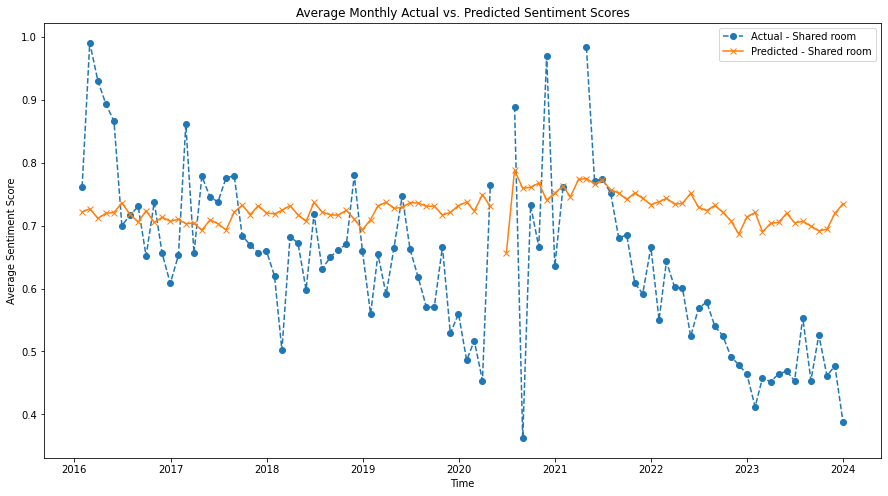

In [132]:
# Plot average actual vs. predicted sentiment scores for the entire dataset
plt.figure(figsize=(15, 8))

room_type = 'Shared room'  # Assuming you are specifically dealing with 'Shared room'

if room_type in best_models:
    actual_length = len(subset_df.loc[subset_df['room_type'] == room_type, 'compound'])
    predicted_length = len(predicted_scores[room_type])

    # Adjust predicted length based on actual length
    adjusted_predicted_scores = predicted_scores[room_type][:actual_length]

    # Resample the data to monthly frequency and calculate the mean
    actual_monthly_means = subset_df.loc[subset_df['room_type'] == room_type, 'compound'].resample('M').mean()
    predicted_monthly_means = pd.Series(adjusted_predicted_scores, index=subset_df.index[:actual_length]).resample('M').mean()

    print(f"Room Type: {room_type}, Actual Length: {actual_length}, Adjusted Predicted Length: {len(adjusted_predicted_scores)}")

    # Plot monthly average actual vs. predicted sentiment scores
    plt.plot(actual_monthly_means.index, actual_monthly_means, label=f'Actual - {room_type}', linestyle='--', marker='o')
    plt.plot(predicted_monthly_means.index, predicted_monthly_means, label=f'Predicted - {room_type}', linestyle='-', marker='x')
else:
    print(f"Room Type: {room_type} - No predictions available.")

plt.title('Average Monthly Actual vs. Predicted Sentiment Scores')
plt.xlabel('Time')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.show()
